In [1]:
import copy
import numpy as np
import numpy.random as rand
import scipy.optimize
from scipy.stats import gamma
import matplotlib.pyplot as plt

In [2]:
TOKENS_NUM = 3 # Number of tokens
UTILITY_RANGES = np.array([10, 1, 1000]) # Upper limit of coefficients in utility function for each token. Lower limit is 0.
INCOME_VECTOR = np.array([1e5, 1e6, 1])
INCOME_LOW_MARGIN, INCOME_HIGH_MARGIN = 0.95, 1.05
EPOCHS_NUM = 10
a = 1.5 # Parameter of gamma distribution
rand_type = "custom"
AMM_LIQUIDITY_TOKEN0 = 1e6
AMM_LIQUIDITY_TOKEN1 = 1e7
AMM_LIQUIDITY_TOKEN2 = 10

# printing options
np.set_printoptions(suppress=True, precision=3)

# Random numbers generator with some distribution laws.
def randWrapper(size, type=None):
    if type == "custom":
        r = gamma.rvs(a, size=size)
        with np.nditer(r, op_flags=['readwrite']) as it:
            for x in it:
                if x > 10.0:
                    x[...] = 10.0
                flag = np.random.rand(1)[0]
                if flag > 0.8:
                    x[...] = 20.0 - x # mirror relative to 10.0
        return r
    else:
        return rand.rand(*size)

5.6724333650721865


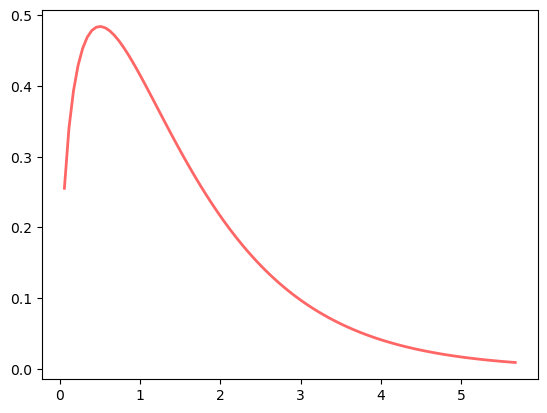

In [3]:
# Draw probability density function for choosen distribution
x = np.linspace(gamma.ppf(0.01, a), gamma.ppf(0.99, a), 100)
print(x[-1])
plt.plot(x, gamma.pdf(x, a), 'r-', lw=2, alpha=0.6, label='gamma pdf');

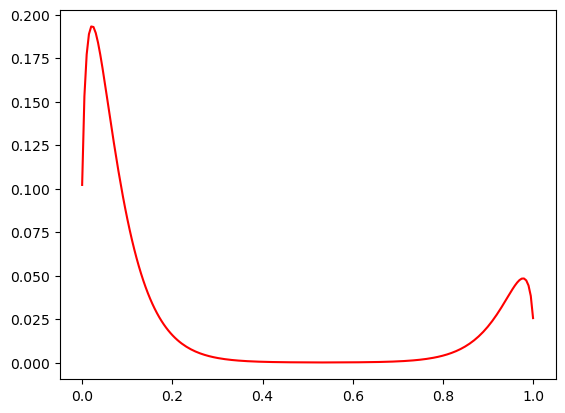

In [4]:
x2 = np.linspace(gamma.ppf(0.01, a), 10., 100)
y2 = gamma.pdf(x2, a)
x3 = np.linspace(0., 1., 200)
y3 = np.hstack((0.4 * y2, 0.1 * y2[::-1]))
plt.plot(x3, y3, 'r-');

In [5]:
class User:
    def __init__(self, startPeriod, utilityFuncGenerator):
        self.start = startPeriod
        self.richness = User.getRichness()
        self.basket = np.zeros(TOKENS_NUM)
        self.utilityCoeffs = User.getUtilityCoeffs()
        self.utilityFunc = utilityFuncGenerator(self, sign=1.0)
        
    def getIncome(self):
        newIncome = self.richness * INCOME_VECTOR * rand.uniform(INCOME_LOW_MARGIN, INCOME_HIGH_MARGIN, TOKENS_NUM)
        self.basket += newIncome
        return newIncome
    
    def seizeBasket(self):
        basket = self.basket[:]
        self.basket = np.zeros(TOKENS_NUM)
        return basket
    
    def addToBasket(self, income):
        self.basket += income
        
    @property
    def utility(self):
        return self.utilityFunc(self.basket)
                
    @staticmethod
    def getRichness():
        return randWrapper((1,), rand_type)[0]
    
    @staticmethod
    def getUtilityCoeffs():
        return UTILITY_RANGES * randWrapper((TOKENS_NUM,), rand_type)

In [6]:
def getObjective(users, sign=-1.0):
    coeffs = np.array([], dtype=float)
    if not isinstance(users, list):
        users = [users]
    for user in users:
        coeffs = np.append(coeffs, user.utilityCoeffs)
    
    def objective(x):
        return sign * np.sum(coeffs * x) / len(users)
    return objective

def getBasket(users):
    basket = np.zeros(TOKENS_NUM, dtype=float)
    for user in users:
        basket += user.seizeBasket()
    return basket

def getConstraints(users_num, basket):
    A = np.eye(TOKENS_NUM)
    for _ in range(users_num - 1):
        A = np.hstack((A, np.eye(TOKENS_NUM)))
        
    return scipy.optimize.LinearConstraint(A, lb=basket, ub=basket, keep_feasible=False)

def getBounds(users_num):
    bnd = ((0, None),)
    return users_num * 3 * bnd

def optimize(users, users_num, obj_func, x0=None):
    basket = getBasket(users)
    constr = getConstraints(users_num, basket)
    bnds = getBounds(users_num)
    x0 = np.zeros(TOKENS_NUM * len(users)) if x0 is None else x0
    res = scipy.optimize.minimize(
        obj_func, 
        x0, 
        method='SLSQP', 
        bounds=bnds, 
        constraints=constr, 
        tol=1e-6)
    return res

def calculateTotalUtility(users):
    utility = 0.0
    for user in users:
        utility += user.utility
    utility /= len(users)
    return utility

In [7]:
def simulate(epochs_num, obj_func_generator, verbose=True):
    users = []
    dist_history = []
    init_dist = None
    for epoch in range(1, epochs_num + 1):
        newUser = User(epoch, obj_func_generator)
        users.append(newUser)
        for user in users:
            user.getIncome()
        util = calculateTotalUtility(users)
        if verbose:
            print(f"{epoch} epoch:")
            print(f"Utility before: {util}")
        obj_func = obj_func_generator(users)
        # Save baskets if restore needed
        old_baskets = []
        for user in users:
            old_baskets.append(user.basket)
        res = optimize(users, len(users), obj_func, init_dist)
        restore = False
        if verbose:
            if res.success:
                print("Optimization succeed.")
            else:
                print("Optimization failed!")
        if res.success:
            init_dist = np.append(res.x, [0., 0., 0.])
            reshapedRes = np.reshape(res.x, (len(users), TOKENS_NUM))
            for ii, user in enumerate(users):
                user.addToBasket(reshapedRes[ii, :])
            new_util = calculateTotalUtility(users)
            if new_util < util:
                restore = True
        else:
            restore = True
            init_dist = None

        if restore:
            for user, old_basket in zip(users, old_baskets):
                _ = user.seizeBasket()
                user.addToBasket(old_basket)
        
        # Save current token distribution
        dist = []
        for user in users:
            dist.append(user.basket)
        dist_history.append(copy.deepcopy(dist))
            
        # Save info about epoch
        if verbose:
            util = calculateTotalUtility(users)
            print(f"Utility after: {util}")
            for user in users:
                print(user.utilityCoeffs)
            print("Baskets")
            for user in users:
                print(user.basket)
            print("======================")
    return dist_history
                 
dist_history = simulate(EPOCHS_NUM, getObjective, verbose=True)

1 epoch:
Utility before: 20265346.71054823
Optimization succeed.
Utility after: 20265346.71054823
[  45.416    2.121 1202.023]
Baskets
[ 304174.267 3039436.889       3.34 ]
2 epoch:
Utility before: 33287724.225649603
Optimization succeed.
Utility after: 79628090.74745353
[  45.416    2.121 1202.023]
[ 192.203    3.107 1091.958]
Baskets
[      0.    5165632.92        7.554]
[ 737040.755 2133324.4         0.   ]
3 epoch:
Utility before: 93234195.01258223
Optimization succeed.
Utility after: 172661074.47309226
[  45.416    2.121 1202.023]
[ 192.203    3.107 1091.958]
[185.429  19.109 533.939]
Baskets
[ 0.    0.   13.91]
[1160084.504       0.          0.   ]
[  199560.103 13501096.474        0.   ]
4 epoch:
Utility before: 160152386.3953356
Optimization succeed.
Utility after: 199579646.860221
[  45.416    2.121 1202.023]
[ 192.203    3.107 1091.958]
[185.429  19.109 533.939]
[  11.264    1.252 3057.586]
Baskets
[0. 0. 0.]
[2092630.667       0.          0.   ]
[       0.    20725688.179   

[ [1. 1. 1.] ]
[ [0.    0.708 1.   ] [1.    0.292 0.   ] ]
[ [0. 0. 1.] [0.853 0.    0.   ] [0.147 1.    0.   ] ]
[ [0. 0. 0.] [1. 0. 0.] [0. 1. 0.] [0. 0. 1.] ]
[ [0.109 0.109 0.106] [0.738 0.038 0.039] [0.065 0.766 0.065] [0.031 0.031 0.735] [0.056 0.057 0.056] ]
[ [0.    0.183 0.   ] [0.674 0.008 0.   ] [0.326 0.8   0.   ] [0.    0.008 1.   ] [0. 0. 0.] [0. 0. 0.] ]
[ [0.    0.158 0.   ] [0.953 0.066 0.   ] [0.    0.712 0.   ] [0.    0.021 0.   ] [0.    0.014 0.   ] [0.    0.014 0.   ] [0.047 0.014 1.   ] ]
[ [0.    0.145 0.   ] [0.803 0.087 0.   ] [0.197 0.497 0.   ] [0.    0.058 0.   ] [0.    0.054 0.   ] [0.    0.054 0.   ] [0.    0.055 1.   ] [0.   0.05 0.  ] ]
[ [0.023 0.116 0.024] [0.509 0.063 0.009] [0.138 0.326 0.015] [0.007 0.044 0.007] [0.013 0.047 0.012] [0.014 0.049 0.015] [0.002 0.036 0.623] [0.144 0.174 0.15 ] [0.15  0.146 0.146] ]
[ [0.034 0.1   0.033] [0.368 0.051 0.013] [0.109 0.244 0.021] [0.01  0.037 0.01 ] [0.018 0.042 0.018] [0.02  0.045 0.021] [0.002 0.027 0.44

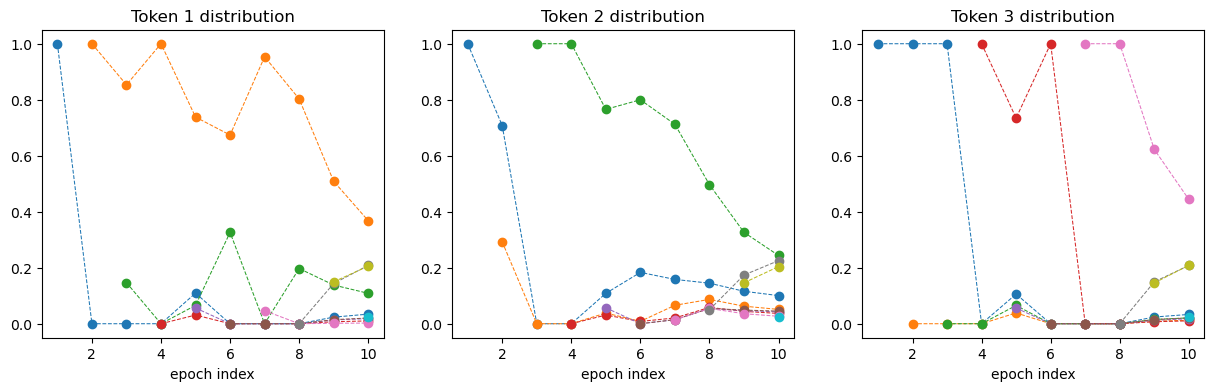

In [8]:
def calculate_token_dist_shares(dist_history, debug=True):
    # Calculate common baskets for all epochs
    epochs_num = len(dist_history)
    baskets = []
    for dist in dist_history:
        basket = np.zeros(3)
        for user_basket in dist:
            basket += user_basket
        baskets.append(basket)
    # Calculate distribution in shares
    dist_h_shares = copy.deepcopy(dist_history)
    for e in range(epochs_num):
        for ii in range(e + 1):
            dist_h_shares[e][ii] = dist_h_shares[e][ii] / baskets[e]
            
    if debug:
        for el in dist_h_shares:
            print(f"[", end=' ')
            for ii in range(len(el)):
                print(el[ii], end=' ')
            print(f"]")
    return dist_h_shares

def plot_token_dist(dist_h_shares):
    epochs_num = len(dist_h_shares)
    fig, ax = plt.subplots(1, TOKENS_NUM, figsize=(15, 4))
    for token_ind in range(TOKENS_NUM):
        ax[token_ind].set_title(f"Token {token_ind + 1} distribution")
        ax[token_ind].set_xlabel("epoch index")

        for user_ind in range(epochs_num):
            user_dist = []
            for epoch_ind in range(user_ind, epochs_num):
                user_dist.append(dist_h_shares[epoch_ind][user_ind][token_ind])
            ax[token_ind].plot(np.arange(user_ind + 1, epochs_num + 1), user_dist, marker='o', linestyle="--", linewidth=0.75)

dist_h_shares = calculate_token_dist_shares(dist_history, debug=True)
plot_token_dist(dist_h_shares)

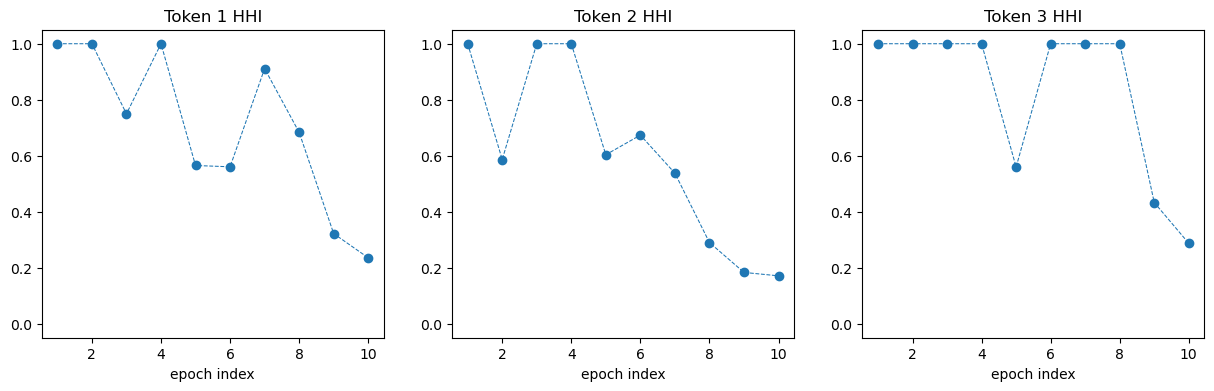

In [9]:
def plot_HHI(dist_h_shares):
    epochs_num = len(dist_h_shares)
    fig, ax = plt.subplots(1, TOKENS_NUM, figsize=(15, 4))
    for token_ind in range(TOKENS_NUM):
        ax[token_ind].set_title(f"Token {token_ind + 1} HHI")
        ax[token_ind].set_xlabel("epoch index")
        ax[token_ind].set_ylim(-.05, 1.05)

        hhi_by_epoch = []
        for epoch_dist in dist_h_shares:
            hhi = 0.
            for user_dist in epoch_dist:
                hhi += user_dist[token_ind]**2
            hhi_by_epoch.append(hhi)
        ax[token_ind].plot(np.arange(1, epochs_num + 1), hhi_by_epoch, marker='o', linestyle="--", linewidth=0.75)
        
plot_HHI(dist_h_shares)

In [10]:
# Simulate Utility function with natural logarithms

def getLogObjective(users, sign=-1.0):
    coeffs = np.array([], dtype=float)
    if not isinstance(users, list):
        users = [users]
    for user in users:
        coeffs = np.append(coeffs, user.utilityCoeffs)
    
    def objective(x, sign=sign):
        return sign * np.sum(coeffs * np.log(x + 1)) / len(users)
    return objective

dist_history = simulate(EPOCHS_NUM, getLogObjective, verbose=True)
dist_h_shares = calculate_token_dist_shares(dist_history, debug=False)

1 epoch:
Utility before: 7415.854390800812
Optimization succeed.
Utility after: 7415.854390800812
[   6.037   18.737 2365.949]
Baskets
[ 1913306.496 19157676.612       18.389]
2 epoch:
Utility before: 5768.969786600749
Optimization succeed.
Utility after: 6452.3892444399235
[   6.037   18.737 2365.949]
[193.701   0.196 827.143]
Baskets
[ 2833150.419 29093160.834       27.524]
[ 919940.775 9935484.319       8.972]
3 epoch:
Utility before: 5317.5926829846185
Optimization succeed.
Utility after: 5651.941980126377
[   6.037   18.737 2365.949]
[193.701   0.196 827.143]
[  16.448    1.311 1151.275]
Baskets
[ 3555619.539 36325848.812       32.22 ]
[ 1642409.896 17168172.298       10.615]
[ 722474.603 7232688.416      15.166]
4 epoch:
Utility before: 4857.9750833764
Optimization succeed.
Utility after: 4895.402363398313
[   6.037   18.737 2365.949]
[193.701   0.196 827.143]
[  16.448    1.311 1151.275]
[ 15.588   5.878 470.303]
Baskets
[ 4243154.817 43003389.988       42.993]
[ 2329945.175 238

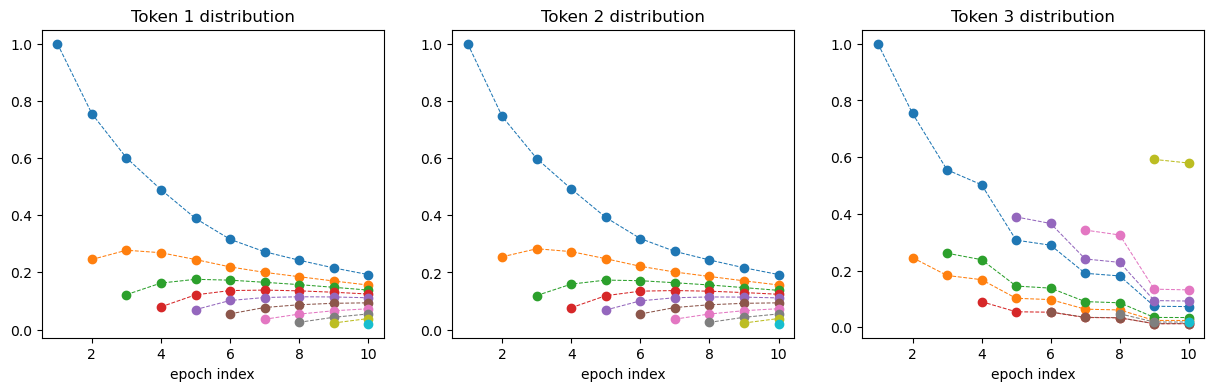

In [11]:
plot_token_dist(dist_h_shares)

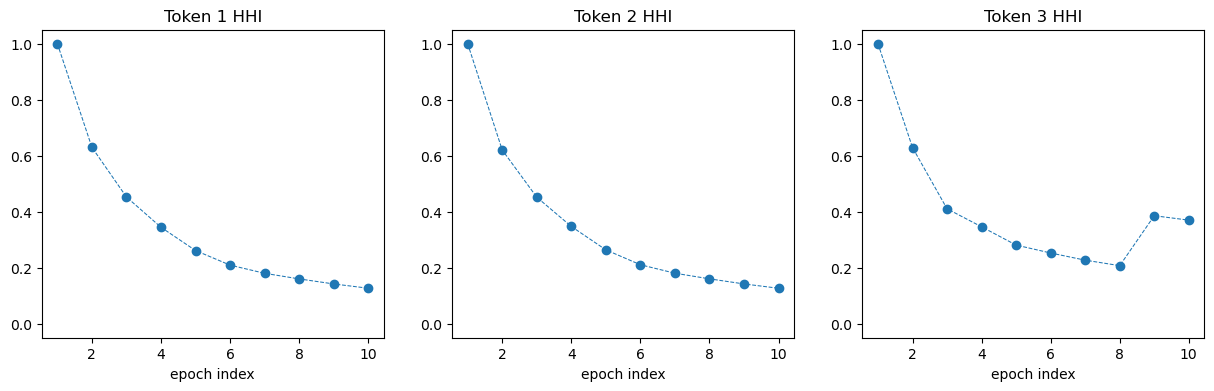

In [12]:
plot_HHI(dist_h_shares)

# AMM Modeling

In [13]:
class AMM:
    def __init__(self, x, y, z):
        self.liquidity = [x, y, z]
        self.k = x * y * z

    def swap(self, data):
        token_inds = {0, 1, 2}
        tx_ind = data[1]
        rx_ind = data[2]
        swap_pair = {tx_ind, rx_ind}
        unused_ind = token_inds - swap_pair
        unused_ind = unused_ind.pop()

        res = self.k / self.liquidity[unused_ind] / (self.liquidity[tx_ind] + data[0]) - self.liquidity[rx_ind]
        assert res < 0, "Oops! Error during swap!"
        self.liquidity[tx_ind] += data[0]
        self.liquidity[rx_ind] += res
        ret = np.zeros(3)
        ret[tx_ind] = -data[0]
        ret[rx_ind] = -res
        return ret


def calculateOptimalTransaction(user, amm):
    ''' return (amount, ind_tx, ind_rx) where
        - amount - amount of transmitted token for exchange
        - ind_tx - index of token transmitted to AMM
        - ind_rx - index of desired token from AMM
    '''
    
    # Same for all cases
    obj_func = lambda x: (-1) * user.utilityFunc(user.basket - x)
    x0 = np.zeros(TOKENS_NUM)
    def AMM_constr(x):
        return (amm.liquidity[0] + x[0])*(amm.liquidity[1] + x[1])*(amm.liquidity[2] + x[2]) - amm.k

    curr_utility = user.utility
    opt_res = None
    
    for unused in range(TOKENS_NUM):
        token_inds = {0, 1, 2}
        swap_pair = tuple(token_inds - {unused})
            
        constr = [
            {'type': 'eq', 'fun': AMM_constr},
            {'type': 'ineq', 'fun': lambda x: -1*x[swap_pair[0]]*x[swap_pair[1]] - np.finfo(float).eps} # x*y < 0
        ]

        bnds = [None, None, None]
        bnds[swap_pair[0]] = (None, user.basket[swap_pair[0]])
        bnds[swap_pair[1]] = (None, user.basket[swap_pair[1]])
        bnds[unused] = (0, 0)
        bnds = tuple(bnds)  # x <= basket_x, y <= basket_y, z == 0
    
        res = scipy.optimize.minimize(
            obj_func, 
            x0, 
            method='SLSQP', 
            bounds=bnds, 
            constraints=constr, 
            tol=1e-6,
            options={'maxiter': 10000})

        if not res.success:
            continue

        assert res.x[unused] < 1e-7, "Optimization failed: unused token changed value!"
        assert res.x[swap_pair[0]] * res.x[swap_pair[1]] < 0, "Optimization failed: x*y >= 0!"
        if res.x[swap_pair[0]] > 0:
            assert res.x[swap_pair[0]] <= user.basket[swap_pair[0]], "Optimization failed: transmitted more token than you had!"
        else:
            assert res.x[swap_pair[1]] <= user.basket[swap_pair[1]], "Optimization failed: transmitted more token than you had!"

        opt_utility = (-1) * obj_func(res.x)
        if opt_utility > curr_utility:
            curr_utility = opt_utility
            opt_res = (res.x[swap_pair[0]], swap_pair[0], swap_pair[1]) if res.x[swap_pair[0]] > 0 else (res.x[swap_pair[1]], swap_pair[1], swap_pair[0])

    return opt_res
    

def simulateAMM(epochs_num, obj_func_generator, amm, verbose=False):
    users = []
    baskets_history = []
    for epoch in range(epochs_num):
        tx_pool = []
        user = User(epoch + 1, obj_func_generator)
        users.append(user)
        for user in users:
            user.getIncome()
        if verbose:
            util = calculateTotalUtility(users)
            print(f"epoch {epoch + 1}")
            print(f"Utility before: {util}")
        for u_ind, user in enumerate(users):
            # Every user calculates his transaction regardless of others.
            user_tx = calculateOptimalTransaction(user, amm)
            if verbose:
                if user_tx is None:
                    print("Optimization Failed!")                   
                else:
                    print("Optimization succeed.")
            if user_tx is not None:
                tx_pool.append((u_ind, user_tx))
        # Shuffle transactions (order of transactions' execution is unknown)
        np.random.shuffle(tx_pool)
        # Execute all transaction sequentially
        for tx in tx_pool:
            exchange_res = amm.swap(tx[1])
            users[tx[0]].addToBasket(exchange_res)
        # Save state for history
        baskets = []
        for user in users:
            baskets.append(user.basket)
        baskets_history.append(copy.deepcopy(baskets))
        
        if verbose:
            util = calculateTotalUtility(users)
            print(f"Utility after: {util}")
            for user in users:
                print(user.utilityCoeffs)
            print("Baskets")
            for user in users:
                print(user.basket)
            print("======================")
    return baskets_history

In [14]:
myswap = AMM(AMM_LIQUIDITY_TOKEN0, AMM_LIQUIDITY_TOKEN1, AMM_LIQUIDITY_TOKEN2)
baskets_history = simulateAMM(EPOCHS_NUM, getObjective, myswap, verbose=True)
dist_h_shares = calculate_token_dist_shares(baskets_history, debug=False)

epoch 1
Utility before: 2788741.9906921755
Optimization succeed.
Utility after: 4542713.027380649
[  4.204   1.117 556.969]
Baskets
[ 190864.959 3347669.086       0.   ]
epoch 2
Utility before: 6158341.448332589
Optimization succeed.
Optimization succeed.
Utility after: 8028154.925371688
[  4.204   1.117 556.969]
[   26.885     1.148 15604.865]
Baskets
[ 372940.978 6275810.124       0.   ]
[ 221297.254 1329815.835       0.   ]
epoch 3
Utility before: 16567325.292722763
Optimization succeed.
Optimization Failed!
Optimization succeed.
Utility after: 17881141.42361404
[  4.204   1.117 556.969]
[   26.885     1.148 15604.865]
[    3.646     1.    16898.697]
Baskets
[ 555281.632 8355168.017       0.   ]
[ 347665.032 2582269.892       1.36 ]
[ 1883013.54 22778751.49        0.  ]
epoch 4
Utility before: 33984014.08480001
Optimization succeed.
Optimization succeed.
Optimization Failed!
Optimization succeed.
Utility after: 35182002.14810744
[  4.204   1.117 556.969]
[   26.885     1.148 15604.8

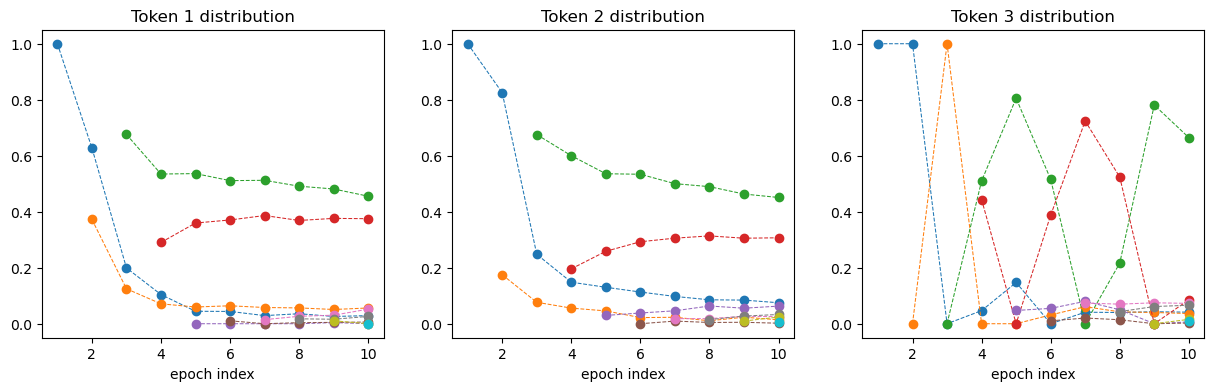

In [15]:
plot_token_dist(dist_h_shares)